# COMP0119 - Acquisition and processing of 3D geometry
## Deep ICP
### Baptiste Moalic

##### Importing modules

In [11]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import sys
import torch
import random
import numpy as np
import datetime
import logging
#import provider
import importlib
import shutil
import argparse
from pathlib import Path
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from pointnet2_utils import PointNetSetAbstractionMsg, PointNetSetAbstraction
from pointnet2_cls_msg import get_model, get_loss
import trimesh
from sklearn.neighbors import KDTree
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.autograd import Variable


In [44]:
from google.colab import files

##### Setting the random seeds

In [4]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

##### Setting the device

In [5]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


##### Model

In [6]:
class DeepVCP(nn.Module):
    
    def __init__(self):
        super().__init__()

        # FE layer
        self.FE_npoint = 1024
        self.FE_radius = 1
        self.FE_nsample1 = 1024
        self.FE_nsample2 = 512
        self.FE_nsample3 = 256
        # The PointNetSetAbstraction class has been imported
        self.sa1 = PointNetSetAbstraction(self.FE_npoint, self.FE_radius, self.FE_nsample1, in_channel = 1+3, mlp = [16, 16, 32], group_all = False)
        self.sa2 = PointNetSetAbstraction(self.FE_npoint, self.FE_radius, self.FE_nsample2, in_channel = 32+3, mlp = [32, 64], group_all = False)
        self.sa3 = PointNetSetAbstraction(self.FE_npoint, self.FE_radius, self.FE_nsample3, in_channel = 64+3, mlp = [64, 64], group_all = False)

        self.FE_DropoutVal = 0.7
        self.FE_MLP = torch.nn.Linear(64, 32)
        self.FE_Dropout = torch.nn.Dropout(self.FE_DropoutVal)

        # Weighting Layer
        self.beta_softplus = 1
        self.N = 64

        self.WeightingLayer_MLP1 = torch.nn.Linear(32, 16)
        self.WeightingLayer_BN1 = torch.nn.BatchNorm1d(self.FE_npoint)
        self.WeightingLayer_MLP2 = torch.nn.Linear(16, 8)
        self.WeightingLayer_BN2 = torch.nn.BatchNorm1d(self.FE_npoint)
        self.WeightingLayer_MLP3 = torch.nn.Linear(8, 1)
        self.WeightingLayer_SP = torch.nn.Softplus(self.beta_softplus)

        # DFE layer
        self.DFE_MLP1 = torch.nn.Linear(36, 32)
        self.DFE_MLP2 = torch.nn.Linear(32, 32)
        self.DFE_MLP3 = torch.nn.Linear(32, 32)
        self.DFE_Maxpool = torch.nn.MaxPool1d(1)
        #padding=0 dilation=1 stride=default or 1

        # CPG layer
        self.CPG_Conv3D1 = torch.nn.Conv3d(32, 16, 3, 1, 1)
        self.CPG_Conv3D2 = torch.nn.Conv3d(16, 4, 3, 1, 1)
        self.CPG_Conv3D3 = torch.nn.Conv3d(4, 1, 3, 1, 1)
        self.CPG_Softmax = torch.nn.Softmax(dim=-1)

        # Sampling candidates layer
        self.Xgrid = ((2*2.0)/0.4) + 1
        self.Ygrid = ((2*2.0)/0.4) + 1
        self.Zgrid = ((2*2.0)/0.25) + 1
        # 8 candidates: fixed


    def FE(self,point_cloud):
        
        # SA layers take [Batch, Features, Nb of points]
        point_cloud = torch.permute(point_cloud, (0, 2, 1))
       
        # Applying the PointNet++ architecture to both the target and source points
        point_cloud_xyz, point_cloud_points = self.sa1(point_cloud[:, :3, :], point_cloud[:, 3:, :]) # SA layers take xyz and features separately
        point_cloud_xyz, point_cloud_points = self.sa2(point_cloud_xyz, point_cloud_points)
        _, point_cloud_points = self.sa3(point_cloud_xyz, point_cloud_points)

        # Go back to [Batch, Nb of points, Features]
        point_cloud_points = torch.permute(point_cloud_points, (0, 2, 1))

        # MLP to go back to 32 features + dropout
        point_cloud_points = self.FE_MLP(point_cloud_points)
        point_cloud_points = self.FE_Dropout(point_cloud_points)

        return point_cloud_points
    

    def sample_candidates(self, weighted_transformed_points, target_point_cloud, target_features):
        """
        INPUT: the TRANSFORMED point, need to apply R and t on them
        RETURNS: the 8 candidates with 36 (xyz+features), to be sliced by ourselves after
        """
    
        res = torch.zeros((1, self.N, 8, 36)) #sticking with 8 candidates (8 grid voxels around each point)
        tree_target = KDTree(torch.squeeze(target_point_cloud[:, :, :3]))

        for kk in range(self.N):
            # completing the 8 candidates as centroids of the grid voxel
            candidate_kk = torch.squeeze(weighted_transformed_points[:, kk, :3] + torch.tensor([self.Xgrid/2, self.Ygrid/2, self.Zgrid/2]))
            _, candidate_idx = tree_target.query(candidate_kk.view(1, -1), 1)
            res[:, kk, 0, :4] = target_point_cloud[:, candidate_idx, :]
            res[:, kk, 0, 4:] = target_features[:, candidate_idx, :]

            candidate_kk = torch.squeeze(weighted_transformed_points[:, kk, :3] + torch.tensor([-self.Xgrid/2, self.Ygrid/2, self.Zgrid/2]))
            _, candidate_idx = tree_target.query(candidate_kk.view(1, -1), 1)
            res[:, kk, 1, :4] = target_point_cloud[:, candidate_idx, :]
            res[:, kk, 1, 4:] = target_features[:, candidate_idx, :]

            candidate_kk = torch.squeeze(weighted_transformed_points[:, kk, :3] + torch.tensor([-self.Xgrid/2, -self.Ygrid/2, self.Zgrid/2]))
            _, candidate_idx = tree_target.query(candidate_kk.view(1, -1), 1)
            res[:, kk, 2, :4] = target_point_cloud[:, candidate_idx, :]
            res[:, kk, 2, 4:] = target_features[:, candidate_idx, :]

            candidate_kk = torch.squeeze(weighted_transformed_points[:, kk, :3] + torch.tensor([self.Xgrid/2, -self.Ygrid/2, self.Zgrid/2]))
            _, candidate_idx = tree_target.query(candidate_kk.view(1, -1), 1)
            res[:, kk, 3, :4] = target_point_cloud[:, candidate_idx, :]
            res[:, kk, 3, 4:] = target_features[:, candidate_idx, :]

            candidate_kk = torch.squeeze(weighted_transformed_points[:, kk, :3] + torch.tensor([self.Xgrid/2, self.Ygrid/2, -self.Zgrid/2]))
            _, candidate_idx = tree_target.query(candidate_kk.view(1, -1), 1)
            res[:, kk, 4, :4] = target_point_cloud[:, candidate_idx, :]
            res[:, kk, 4, 4:] = target_features[:, candidate_idx, :]

            candidate_kk = torch.squeeze(weighted_transformed_points[:, kk, :3] + torch.tensor([-self.Xgrid/2, self.Ygrid/2, -self.Zgrid/2]))
            _, candidate_idx = tree_target.query(candidate_kk.view(1, -1), 1)
            res[:, kk, 5, :4] = target_point_cloud[:, candidate_idx, :]
            res[:, kk, 5, 4:] = target_features[:, candidate_idx, :]

            candidate_kk = torch.squeeze(weighted_transformed_points[:, kk, :3] + torch.tensor([-self.Xgrid/2, -self.Ygrid/2, -self.Zgrid/2]))
            _, candidate_idx = tree_target.query(candidate_kk.view(1, -1), 1)
            res[:, kk, 6, :4] = target_point_cloud[:, candidate_idx, :]
            res[:, kk, 6, 4:] = target_features[:, candidate_idx, :]

            candidate_kk = torch.squeeze(weighted_transformed_points[:, kk, :3] + torch.tensor([self.Xgrid/2, -self.Ygrid/2, -self.Zgrid/2]))
            _, candidate_idx = tree_target.query(candidate_kk.view(1, -1), 1)
            res[:, kk, 7, :4] = target_point_cloud[:, candidate_idx, :]
            res[:, kk, 7, 4:] = target_features[:, candidate_idx, :]

        return res


    def WeightingLayer(self, output_DFE_source):
        
        # MLP layers
        w1 = self.WeightingLayer_MLP1(output_DFE_source)
        bn1 = self.WeightingLayer_BN1(w1).clamp(min=0) #clamp == ReLU
        w2 = self.WeightingLayer_MLP2(bn1)
        bn2 = self.WeightingLayer_BN2(w2).clamp(min=0)
        w3 = self.WeightingLayer_MLP3(bn2)
        output_MLP_weights = self.WeightingLayer_SP(w3)

        # Recovering only the N biggest points (wrt features)
        output_MLP_weights = torch.permute(output_MLP_weights, (0, 2, 1)) #we take the N points, not features
        topk_indices = torch.squeeze(torch.topk(output_MLP_weights, self.N)[1]) #outputs Tensor((1,2)), need to squeeze

        return topk_indices
    
    
    def sampleFromTopk(self, topk_indices, point_cloud, thirty_two):

        if(thirty_two):
            output_topk_xyz = torch.zeros((1, self.N, 32))

            for kk in range(self.N):
                output_topk_xyz[:, kk, :] = point_cloud[:, int(topk_indices[kk].item()), :] # top_k indices[kk] = Tensor(int), need to .item() then int

        else:
            output_topk_xyz = torch.zeros((1, self.N, 4))

            for kk in range(self.N):
                output_topk_xyz[:, kk, :] = point_cloud[:, int(topk_indices[kk].item()), :] # top_k indices[kk] = Tensor(int), need to .item() then int

        return output_topk_xyz
    

    def DFE(self, source, candidates):
          
        # the MaxPool only takes 2 or 3 dims
        source = torch.squeeze(source)
        candidates = torch.squeeze(candidates)

        # Processing the source points
        h1_source = self.DFE_MLP1(source)
        h2_source = self.DFE_MLP2(h1_source)
        h3_source = self.DFE_MLP3(h2_source)
        # We have K=1, so we will not use the Maxpool layer
        #h3_source = torch.permute(h3_source, (0, 1, 3, 2)) # because we aggregate over K and not 32
        #output_source = self.DFE_Maxpool(h3_source)
        #output_source = torch.squeeze(output_source) # to go from [Batch, Nb of points, 32, 1] to  [Batch, Nb of points, 32]
        output_source = h3_source

        # Processing the target points
        h1_candidates = self.DFE_MLP1(candidates)
        h2_candidates = self.DFE_MLP2(h1_candidates)
        h3_candidates = self.DFE_MLP3(h2_candidates)
        # We have K=1, so we will not use the Maxpool layer
        #h3_candidates = torch.permute(h3_candidates, (0, 1, 2, 4, 3)) # extra C dimension
        #output_candidates = self.DFE_Maxpool(h3_candidates)
        #output_candidates = torch.squeeze(output_candidates)
        output_candidates = h3_candidates

        return output_source, output_candidates
    

    def CPG(self, source_dfe_output, target_dfe_output, candidates):

        source_dfe_output = torch.squeeze(source_dfe_output) #keep [Nb of points, Nb of features]
        source_dfe_output = torch.unsqueeze(torch.unsqueeze(torch.unsqueeze(source_dfe_output, -1), -1), -1) #to have the correct dim for Conv3D

        source_cpg = self.CPG_Conv3D1(source_dfe_output)
        source_cpg = self.CPG_Conv3D2(source_cpg)
        source_cpg = self.CPG_Conv3D3(source_cpg)
        source_cpg = self.CPG_Softmax(torch.squeeze(source_cpg))
        
        target_dfe_output = torch.squeeze(target_dfe_output) #keep [Nb of points, Nb of candidates, Nb of features]
        target_dfe_output = target_dfe_output.view(-1, 32) #to have the same structure as source_dfe_output
        target_dfe_output = torch.unsqueeze(torch.unsqueeze(torch.unsqueeze(target_dfe_output, -1), -1), -1)

        target_cpg = self.CPG_Conv3D1(target_dfe_output)
        target_cpg = self.CPG_Conv3D2(target_cpg)
        target_cpg = self.CPG_Conv3D3(target_cpg)
        target_cpg = target_cpg.view(-1, 8, 1) #go back to normal shape
        target_cpg = self.CPG_Softmax(torch.squeeze(target_cpg))

        output_weighted = torch.zeros((self.N, 3))
        candidates = torch.squeeze(candidates)
        for nn in range(self.N):
            sum_nn = 0
            for cc in range(8):
                output_weighted[nn, :] += candidates[nn, cc, :3] * target_cpg[nn, cc].item()
                sum_nn += target_cpg[nn, cc].item()
            output_weighted[nn, :] = output_weighted[nn, :] / sum_nn

        return output_weighted
    
    def forward(self, source, target, R, t):
        """
        INPUT:  source: (1, 1024, 4) = (batch_size, nb_of_points, xyz+reflectance)
                target: same
                R and t: rotation and translation vectors of the ground truth
        OUTPUT: N_source: (64, 3) = (nb_of_best_points, xyz), N chosen points from the source
                output_CPG: (64, 3) = (same), N estimated target points
        """

        # Feature extraction layer 
        # (1, 1024, 32)
        #print(type(source))
        FE_source = self.FE(source)
        FE_target = self.FE(target)
        # (1, 1024, 4)
        
        # Weighting layer (only for the source)
        # Obtaining the best indices
        weighting_idx = self.WeightingLayer(FE_source)
        # Retrieving their coordinates
        N_source = self.sampleFromTopk(weighting_idx, source, False) # (1, 64, 4)
        N_source_feat = self.sampleFromTopk(weighting_idx, FE_source, True) # (1, 64, 32)

        # Sampling candidates
        # First, we sample from the transformed source point cloud, so we need to apply R and t to N_souce
        N_source = torch.squeeze(N_source) # (64, 4)
        N_source[:, :3] = torch.mm(torch.squeeze(N_source[:, :3]), R) + t
        N_source = torch.unsqueeze(N_source, 0) # (1, 64, 4)
        # Using the layer to sample the candidates
        candidates = self.sample_candidates(N_source, target, FE_target)
        # (1, 64, 8, 36)

        # Deep Feature Embedding layer
        # We have to concatenate xyzr and features for the N source point cloud
        # The candidates are already concatenated (last dim == 36)
        concat_source_DFE = torch.hstack((torch.squeeze(N_source), torch.squeeze(N_source_feat)))
        concat_source_DFE = torch.unsqueeze(concat_source_DFE, 0) # (1, 64, 36)
        # DFE layer
        DFE_source, DFE_target = self.DFE(concat_source_DFE, candidates)
        DFE_source = torch.unsqueeze(DFE_source, 0) # (1, 64, 32)
        DFE_target = torch.unsqueeze(DFE_target, 0) # (1, 64, 8, 32)

        # CPG layer
        output_CPG = self.CPG(DFE_source, DFE_target, candidates) # (64, 3)
        
        N_source = torch.squeeze(N_source) # (64, 4)
        return N_source[:, :3], output_CPG

#end_solution

##### Loss

In [7]:
def DeepVCP_loss(N_source, R, t, output_CPG, alpha):

    L1_loss = torch.nn.L1Loss(reduction='mean')

    # loss_1: local neighborhood
    # Moving the xi to yi_gt with R and t
    y_gt = torch.mm(N_source, R) + t
    loss_1 = L1_loss(y_gt, output_CPG)

    # loss_2: global
    # Let's first compute R_est and t_est
    N_source_mean = torch.mean(N_source, 0)
    output_CPG_mean = torch.mean(output_CPG, 0)
    #print(output_CPG_mean.shape)
    N_source_tilde = N_source - N_source_mean
    output_CPG_tilde = output_CPG - output_CPG_mean
    A = torch.mm(torch.transpose(N_source_tilde, 0, 1), output_CPG_tilde)
    U, _, Vt = torch.linalg.svd(A)
    R_est = torch.mm(torch.transpose(Vt, 0, 1), torch.transpose(U, 0, 1))
    #print(R_est.shape)
    t_est = N_source_mean - torch.mm(torch.unsqueeze(output_CPG_mean, 0), R_est)  
    # computing the loss
    loss_2 = L1_loss(y_gt, torch.mm(N_source, R_est) + t_est)

    loss_total = alpha*loss_1 + (1-alpha)*loss_2

    return loss_total

##### Auxiliary functions
Imported from coursework 1, functions to perform ICP, to add roation/noise to meshes

In [8]:
def PCA_normal_estimation(surface_points, k):
    num_points, _ = surface_points.shape
    tree = KDTree(surface_points)
    _, indices = tree.query(surface_points, k)
    normals = np.zeros([num_points,3])
    curvatures = np.zeros(num_points)
    for point in range(num_points):
        neighbours = surface_points[indices[point],:]
        mean = np.mean(neighbours,axis=0)
        neighbours_adjust = neighbours - mean
        covariance_matrix = np.cov(neighbours_adjust.T)
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
        sorted_values = np.argsort(-eigenvalues)
        eigenvalues = eigenvalues[sorted_values]
        curvature = abs(eigenvalues[2]) / (abs(eigenvalues[0])+abs(eigenvalues[1])+abs(eigenvalues[2]))
        curvatures[point] = curvature
        eigenvectors = eigenvectors[:,sorted_values]
        normal = eigenvectors[:,2]
        nn = np.linalg.norm(normal)
        normal = normal / nn
        normals[point,:] = normal
    return normals, curvatures

In [9]:
def rotation_mesh(mesh_of_interest, angle):
    new_mesh = mesh_of_interest.copy()
    
    choice_of_method = np.random.randint(0, 3)
    # Angle should be in radians
    if(choice_of_method==0):
        R = np.array([[1, 0, 0], [0, np.cos(angle), -np.sin(angle)], [0, np.sin(angle), np.cos(angle)]])
    if(choice_of_method==1):
        R = np.array([[np.cos(angle), 0, np.sin(angle)], [0, 1, 0], [-np.sin(angle), 0, np.cos(angle)]])
    else:
        R = np.array([[np.cos(angle), -np.sin(angle), 0], [np.sin(angle), np.cos(angle), 0], [0, 0, 1]])
    transform_matrix = np.eye(4)
    transform_matrix[:3, :3] = R.T # Need to transpose for trimesh.apple_transform
    
    new_mesh.apply_transform(transform_matrix)
    
    return new_mesh

In [10]:
def Rt_pt2pt(p, q):
    # Assuming that p and q have the same dimensions
    # p.shape = (nb_pts, 3)
    
    # Following the ICP algorithm seen in class
    p_mean = np.mean(p, axis=0)
    q_mean = np.mean(q, axis=0)
    p_tilde = p - p_mean
    q_tilde = q - q_mean
    
    A = np.transpose(p_tilde) @ q_tilde
    
    U, S, Vt = np.linalg.svd(A, compute_uv=True)
    
    R = np.transpose(Vt) @ np.transpose(U)
    t = p_mean - (q_mean @ R)
    
    return R, t

In [11]:
def add_noise_mesh(mesh, std):
    mesh_copy = mesh.copy()
    
    # We scale the normal noise according to the smallest bounding value for each coordinate
    # /!\ We use the centered mesh
    noise_x = std*np.random.randn(mesh_copy.vertices.shape[0])*max(abs(np.amin(mesh_copy.vertices[:, 0])),abs(np.amax(mesh_copy.vertices[:, 0])))
    noise_y = std*np.random.randn(mesh_copy.vertices.shape[0])*max(abs(np.amin(mesh_copy.vertices[:, 1])),abs(np.amax(mesh_copy.vertices[:, 1])))
    noise_z = std*np.random.randn(mesh_copy.vertices.shape[0])*max(abs(np.amin(mesh_copy.vertices[:, 2])),abs(np.amax(mesh_copy.vertices[:, 2])))

    # Adding noise to each coordinate
    mesh_copy.vertices[:, 0] += noise_x
    mesh_copy.vertices[:, 1] += noise_y
    mesh_copy.vertices[:, 2] += noise_z
    
    return mesh_copy

In [12]:
def ICP_pt2pt(p, q, nb_of_iterations, need_epsilon=False, epsilon=1e-3):

    bool_end_it = True
    ssd_track = np.array([])
    #transform_matrices = np.zeros((4, 4, nb_of_iterations))
    transform_matrices = np.zeros((nb_of_iterations, 4, 4))
    # Creating the tree for nearest neighbours (for iteration 0)
    
    
    # First, sub-sampling and aligning
    # We only sub-sample p, and we'll find the nb of q correspondences after
    # We start by defining a random generator of integers (we sample uniformly)
    #rng = np.random.default_rng()
    #sub_indices = rng.choice(p.shape[0], nb_subsampling, replace=False)

    tree_q = KDTree(q)
    
    for nb_it in range(nb_of_iterations):
    
        # Let's now look for the nearest neighbour of each subsampled point
        q_corr = np.zeros_like(p)
        for k in range(q_corr.shape[0]):
            _, nn_idx = tree_q.query(p[k,:].reshape(1, -1), 1)
            q_corr[k, :] = q[nn_idx, :]
            
        # Computing R, t
        R, t = Rt_pt2pt(p, q_corr)
        
        # Storing in transform_matrices
        transform_matrices[nb_it, :3, :3] = R
        transform_matrices[nb_it, :3, 3] = t
        transform_matrices[nb_it, 3, 3] = 1
        
        # Applying the transform
        q = (q @ R) + t
        
        # Computing the new tree
        tree_q = KDTree(q)
        
        # Computing the SSD error
        ssd_error = np.sum((p-q)**2)
        
        if((nb_it>0) and (abs(ssd_error-ssd_track[-1])<epsilon) and need_epsilon):
            ssd_track = np.append(ssd_track, ssd_error)
            bool_end_it = False
            print("The algorithm has reached the desired precision.")
            break;
            
        ssd_track = np.append(ssd_track, ssd_error)
        
    return R, t

In [13]:
def ICP_pt2plane(p, q, nb_of_iterations, k, k_normal, need_epsilon=False, epsilon=1e-3):

    bool_end_it = True
    #transform_matrices = np.zeros((4, 4, nb_of_iterations))
    transform_matrices = np.zeros((nb_of_iterations, 4, 4))
    ssd_track = np.array([])
    # Creating the tree for nearest neighbours (for iteration 0)
    
    
    # First, sub-sampling and aligning
    # We only sub-sample p, and we'll find the nb of q correspondences after
    # We start by defining a random generator of integers (we sample uniformly)
    #rng = np.random.default_rng()
    #sub_indices = rng.choice(p.shape[0], nb_subsampling, replace=False)

    # Subsampling
    #p = M1_c.sample(nb_subsampling)
    #q = M2_c.sample(nb_subsampling)
    
    tree_q = KDTree(q)
    
    normals, _ = PCA_normal_estimation(p, k)
    
    for nb_it in range(nb_of_iterations):
    
        # Let's now look for the nearest neighbour of each subsampled point
        q_corr = np.zeros_like(p)
        for k in range(q_corr.shape[0]):
            _, nn_idx = tree_q.query(p[k,:].reshape(1, -1), k_normal)
            nn_idx = np.reshape(nn_idx, -1)
            min_idx = nn_idx[0]
            min_dist = abs(np.dot(p[k, :]-q[nn_idx[0], :], normals[k, :]))
            for l in range(1, k_normal):
                dist_l = abs(np.dot(p[k, :]-q[nn_idx[l], :], normals[k, :]))
                if(dist_l < min_dist):
                    min_idx = nn_idx[l]
                    min_dist = dist_l
            q_corr[k, :] = q[min_idx, :]
                
            
        # Computing R, t
        R, t = Rt_pt2pt(p, q_corr)
        
        # Storing in transform_matrices
        transform_matrices[nb_it, :3, :3] = R
        transform_matrices[nb_it, :3, 3] = t
        transform_matrices[nb_it, 3, 3] = 1
        
        # Applying the transform
        q = (q @ R) + t
        
        # Computing the new tree
        tree_q = KDTree(q)
        
        # Computing the SSD error
        ssd_error = np.sum((p-q)**2)
        
        if((nb_it>0) and (abs(ssd_error-ssd_track[-1])<epsilon) and need_epsilon):
            ssd_track = np.append(ssd_track, ssd_error)
            bool_end_it = False
            break;
            
        ssd_track = np.append(ssd_track, ssd_error)

    return R, t

##### Dataset

In [14]:
class BunnyDataset(Dataset):
    
    def __init__(self, nb_of_training_bunnies, bunny_mesh1, bunny_mesh2, bunny_mesh3, bunny_mesh4, bunny_mesh5, bunny_mesh6):
        super().__init__()
        #solution
        self.nb_of_training_bunnies = nb_of_training_bunnies
        self.bunny_mesh1 = bunny_mesh1
        self.bunny_mesh1.vertices = self.bunny_mesh1.vertices - self.bunny_mesh1.centroid
        self.bunny_mesh2 = bunny_mesh2
        self.bunny_mesh2.vertices = self.bunny_mesh2.vertices - self.bunny_mesh2.centroid
        self.bunny_mesh3 = bunny_mesh3
        self.bunny_mesh3.vertices = self.bunny_mesh3.vertices - self.bunny_mesh3.centroid
        self.bunny_mesh4 = bunny_mesh4
        self.bunny_mesh4.vertices = self.bunny_mesh4.vertices - self.bunny_mesh4.centroid
        self.bunny_mesh5 = bunny_mesh5
        self.bunny_mesh5.vertices = self.bunny_mesh5.vertices - self.bunny_mesh5.centroid
        self.bunny_mesh6 = bunny_mesh6
        self.bunny_mesh6.vertices = self.bunny_mesh6.vertices - self.bunny_mesh6.centroid
        #end_solution


    def __len__(self):
        
        #solution
        #
        #end_solution
        
        return self.nb_of_training_bunnies

    #def __getitem__(self, idx):
    def __getitem__(self, idx):

        nb_sampling = 1024
        
        #solution
        bunny_nb = np.random.randint(0, 6)

        #print('yo1')
        if(bunny_nb==0):
            bunny_item = self.bunny_mesh1
        elif(bunny_nb==1):
            bunny_item = self.bunny_mesh2
        elif(bunny_nb==2):
            bunny_item = self.bunny_mesh3
        elif(bunny_nb==3):
            bunny_item = self.bunny_mesh4
        elif(bunny_nb==4):
            bunny_item = self.bunny_mesh5
        else:
            bunny_item = self.bunny_mesh6
        #print('yo2')
        # Rotation
        bunny_data = rotation_mesh(bunny_item, np.random.uniform(0, 1)*0.45)
        #print('yo3')
        # Noise
        bunny_data = add_noise_mesh(bunny_data, np.random.uniform(0, 1)*0.04)
        #print('yo4')
        # Sampling
        bunny_data_pts = bunny_data.sample(nb_sampling).astype(np.float32)
        bunny_item_pts = bunny_item.sample(nb_sampling).astype(np.float32)
        #print('yo5')
        # GT transformation
        # Point-to-plane
        #R_data, t_data = ICP_pt2plane(bunny_data_pts, bunny_item_pts, 20, 2, 2)
        # Point-to-point
        R_data, t_data = ICP_pt2pt(bunny_data_pts, bunny_item_pts, 12)
        #print('yo6')
        # Formatting to Pytorch
        bunny_data_pts = torch.from_numpy(bunny_data_pts)
        bunny_data_pts = torch.hstack((bunny_data_pts, torch.zeros((nb_sampling, 1))))
        bunny_item_pts = torch.from_numpy(bunny_item_pts)
        bunny_item_pts = torch.hstack((bunny_item_pts, torch.zeros((nb_sampling, 1))))
        R_data = torch.from_numpy(R_data)
        t_data = torch.from_numpy(t_data)
        #print('yo7')
        #end_solution

        return (bunny_data_pts, bunny_item_pts, R_data, t_data)

##### Importing the meshes we will use as data

In [16]:
# Loading the meshes
bun000 = trimesh.load('bun000_v2.ply', process=False) 
bun045 = trimesh.load('bun045_v2.ply', process=False) 
bun090 = trimesh.load('bun090_v2.ply', process=False) 
bun180 = trimesh.load('bun180_v2.ply', process=False) 
bun270 = trimesh.load('bun270_v2.ply', process=False) 
bun315 = trimesh.load('bun315_v2.ply', process=False) 

##### Training function

Calls DeepVCP_model, bunny_train_dataloader etc... that are initialized AFTER the function!

In [17]:
def training_step_deepvcp(epochs):

    batch_size = 1

    plot_train_loss = []
    plot_valid_loss = []

    
    for k in range(epochs):
        # Train mode
        DeepVCP_model.train()

        # Initializing the training loss
        train_loss = 0

        for data in bunny_train_dataloader:

            # Retrieving the matrices from the data
            bunny_source = data[0] # (1, 4096, 4)
            bunny_target = data[1] # (1, 4096, 4)
            R_gt = torch.squeeze(data[2]) # (3, 3)
            t_gt = data[3] # (1, 3)
            
            #CUDA
            """
            bunny_source.cuda()
            bunny_target.cuda()
            R_gt.cuda()
            t_gt.cuda()
            
            print('aa')
            print(type(bunny_source))
            """

            # Initializing the optimizers
            DeepVCP_optimizer.zero_grad()

            # Forward pass
            N_source, output_CPG = DeepVCP_model.forward(bunny_source, bunny_target, R_gt, t_gt)

            # Computing the loss
            loss = DeepVCP_loss(N_source, R_gt, t_gt, output_CPG, 0.5)

            # Backward pass
            loss.backward()
            train_loss += loss.item() 
            DeepVCP_optimizer.step()
            
        plot_train_loss.append(train_loss)
        print('Train Epoch: {} \tLoss: {:.6f}'.format(k, loss.item()))

        # Validation mode
        DeepVCP_model.eval()

        # Initializing the validation loss
        valid_loss = 0

        for data in bunny_train_dataloader:

            # Retrieving the matrices from the data
            bunny_source = data[0] # (1, 4096, 4)
            bunny_target = data[1] # (1, 4096, 4)
            R_gt = torch.squeeze(data[2]) # (3, 3)
            t_gt = data[3] # (1, 3)
            
            #CUDA
            """
            bunny_source.to(device)
            bunny_target.to(device)
            R_gt.to(device)
            t_gt.to(device)
            print('b')
            print(type(bunny_source))
            """
            
            # Forward pass
            N_source, output_CPG = DeepVCP_model.forward(bunny_source, bunny_target, R_gt, t_gt)

            # Computing the loss
            loss = DeepVCP_loss(N_source, R_gt, t_gt, output_CPG, 0.5)
            valid_loss += loss.item()

        plot_valid_loss.append(valid_loss)
        print('Validation Epoch: {} \tLoss: {:.6f}'.format(k, loss.item()))

    #Plotting
    plt.figure(figsize=(15,15))
    plt.suptitle("Training and validation loss for our DeepICP on the bunny dataset")
    plt.subplot(121)
    plt.plot(plot_train_loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title("Training loss")
    plt.subplot(122)
    plt.plot(plot_valid_loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title("Validation loss")
    plt.show()

    return plot_train_loss, plot_valid_loss

#end_solution


##### Training procedure

Initializing the datasets

In [18]:
# Datasets
bunny_train = BunnyDataset(20, bun000, bun045, bun090, bun180, bun270, bun315)
bunny_test = BunnyDataset(4, bun000, bun045, bun090, bun180, bun270, bun315)

Initializing the dataloader, model and optimizer

In [19]:
# Dataloader, model and optimizer
bunny_train_dataloader = DataLoader(bunny_train,batch_size=1)
bunny_test_dataloader = DataLoader(bunny_test,batch_size=1)


DeepVCP_model = DeepVCP()
# CUDA
"""
DeepVCP_model.to(device)
"""

DeepVCP_optimizer = optim.Adam(DeepVCP_model.parameters())


Training

Train Epoch: 0 	Loss: 0.015952
Validation Epoch: 0 	Loss: 0.031140
Train Epoch: 1 	Loss: 0.029437
Validation Epoch: 1 	Loss: 0.024942
Train Epoch: 2 	Loss: 0.021332
Validation Epoch: 2 	Loss: 0.022581
Train Epoch: 3 	Loss: 0.023609
Validation Epoch: 3 	Loss: 0.033663
Train Epoch: 4 	Loss: 0.026064
Validation Epoch: 4 	Loss: 0.029532


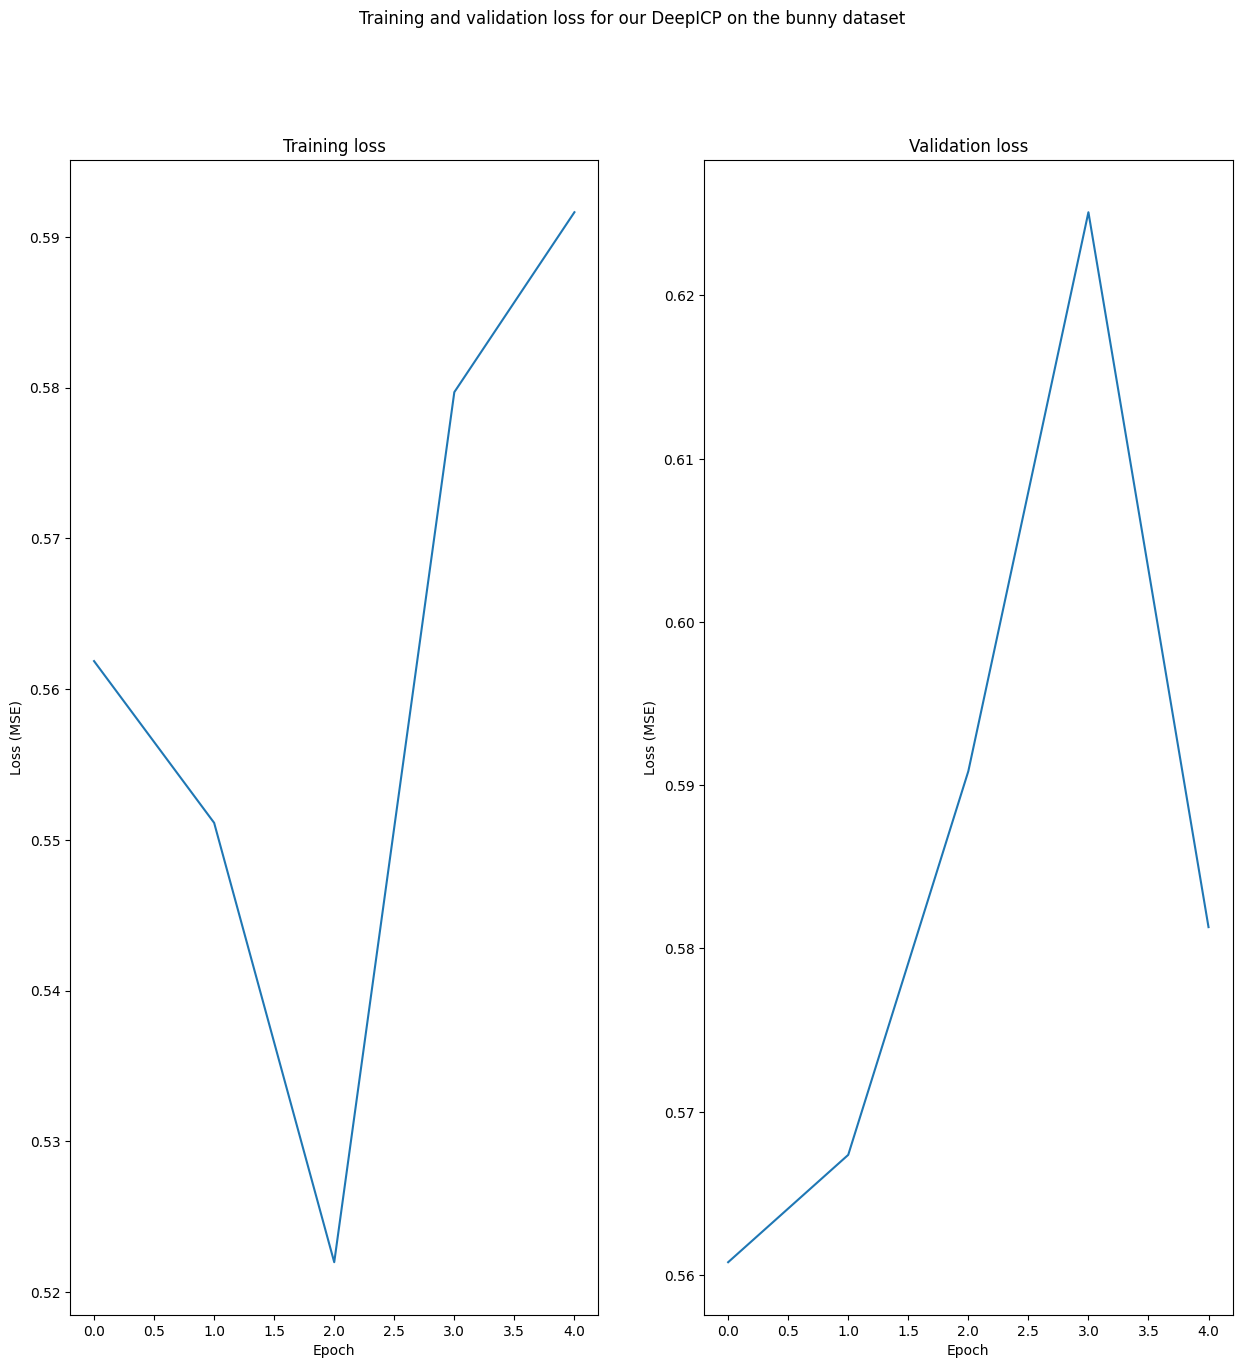

In [41]:
# Training
epochs = 5
loss_train_deepvcp, loss_test_deepvcp = training_step_deepvcp(epochs)

Saving the state of our model

In [42]:
torch.save(DeepVCP_model, "deepvcp_best.pth")

We have trained the model on Google Colab, therefore we use files.download

In [45]:
files.download("deepvcp_best.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Results

Load only the following cell to load the trained model

In [20]:
DeepVCP_res = torch.load("deepvcp_best.pth")

We will try to perform registration on the different bunnies to see if there has been improvement or not.
We will start by defining a function estimating R and t

In [22]:
def R_t_est(N_source, output_CPG):
    N_source_mean = torch.mean(N_source, 0)
    output_CPG_mean = torch.mean(output_CPG, 0)
    N_source_tilde = N_source - N_source_mean
    output_CPG_tilde = output_CPG - output_CPG_mean
    A = torch.mm(torch.transpose(N_source_tilde, 0, 1), output_CPG_tilde)
    U, _, Vt = torch.linalg.svd(A)
    R_est = torch.mm(torch.transpose(Vt, 0, 1), torch.transpose(U, 0, 1))
    t_est = N_source_mean - torch.mm(torch.unsqueeze(output_CPG_mean, 0), R_est)  
    return R_est, t_est

Let's try for bun000 and bun045:

In [23]:
# Data
bun000_pts = bun000.sample(1024).astype(np.float32)
bun045_pts = bun045.sample(1024).astype(np.float32)
R_data, t_data = ICP_pt2pt(bun000_pts, bun045_pts, 12)
bun000_pts = torch.from_numpy(bun000_pts)
bun000_pts = torch.hstack((bun000_pts, torch.zeros((1024, 1))))
bun045_pts = torch.from_numpy(bun045_pts)
bun045_pts = torch.hstack((bun045_pts, torch.zeros((1024, 1))))
R_data = torch.from_numpy(R_data)
t_data = torch.from_numpy(t_data)

In [32]:
# Forward pass
N_source, output_CPG = DeepVCP_res.forward(torch.unsqueeze(bun000_pts, 0), torch.unsqueeze(bun045_pts, 0), R_data, t_data)

In [33]:
N_source_old = N_source
output_CPG_old = output_CPG

In [48]:
N_source = N_source_old
output_CPG = output_CPG_old

In [50]:
# Exporting the outputs of the NN
# Back to numpy format
N_source = N_source.detach().cpu().numpy()
output_CPG = output_CPG.detach().cpu().numpy()

"\n# Trimesh format\nN_source = trimesh.util.array_to_encoded(N_source)\noutput_CPG = trimesh.util.array_to_encoded(output_CPG)\n# Exporting\nN_source.export('N_source001.ply')\noutput_CPG.export('output_CPG001.ply')\n"

In [63]:
bun000_pts = bun000_pts.detach().cpu().numpy()
bun000_pts = bun000_pts[:, :3]

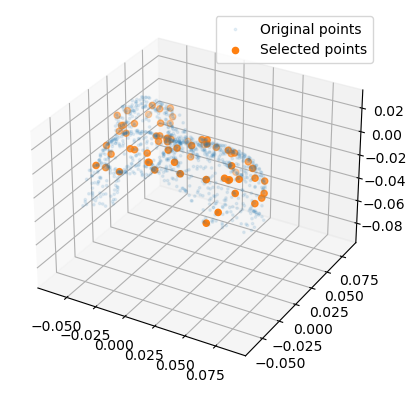

In [80]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(bun000_pts[:, 0], bun000_pts[:, 1], bun000_pts[:, 2], s=3, alpha=0.1, label='Original points')
ax.scatter(N_source[:, 0], N_source[:, 1], N_source[:, 2], s=20, label='Selected points')
plt.legend()
plt.show()

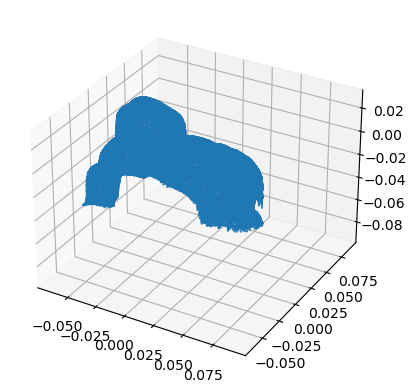

In [85]:
bun000_full_pts = bun000.sample(100000)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(bun000_full_pts[:, 0], bun000_full_pts[:, 1], bun000_full_pts[:, 2], s=0.1)
plt.show()

In [81]:
output_CPG

array([[ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.01693043],
       [ 0.00688888, -0.00161071, -0.016